# Classification. Linear models and KNN

In [1]:
import logging
from sklearn import metrics
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [7]:
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
count_survived = data['Survived'].value_counts()[1]
count_survived

342

In [9]:
data_survived = data[data['Survived']==1]
data_deceased = data[data['Survived']==0]

In [10]:
data_survived['Sex'].value_counts()

female    233
male      109
Name: Sex, dtype: int64

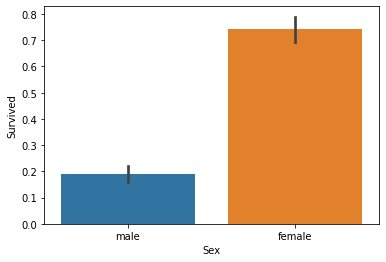

In [11]:
sns.barplot(x="Sex", y="Survived", data=data)

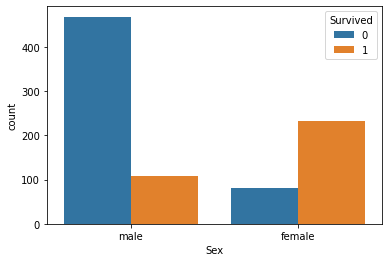

In [12]:
sns.countplot('Sex', data=data, hue="Survived")

Изначально мужчин на корабле больше чем женщин, но женщин выжило больше чем мужчин. Это объясняется тем, что в основном старались спасти женщин, сажали их на шлюпки первыми.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89ba8fc100>]],
      dtype=object)

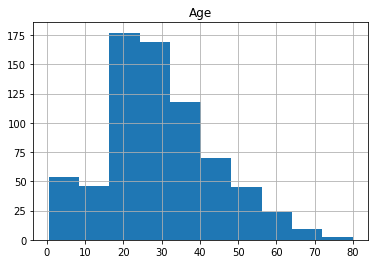

In [13]:
data.hist(column='Age')

In [14]:
data_survived['Age'].median(), data_deceased['Age'].median()

(28.0, 28.0)

In [15]:
data_survived['Age'].mean(), data_deceased['Age'].mean()

(28.343689655172415, 30.62617924528302)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89ba87deb0>]],
      dtype=object)

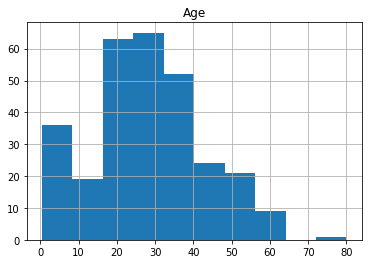

In [16]:
data_survived.hist(column='Age')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89ba802d60>]],
      dtype=object)

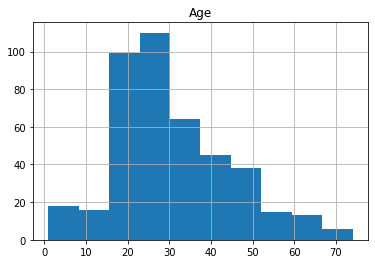

In [17]:
data_deceased.hist(column='Age')

Заметна разница в том, что молодых людей, в особенности до 20 старались так же спасти. Объясняется простым правилом "Женщин и детей спасать в первую очередь"

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

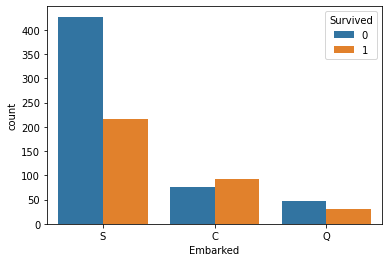

In [18]:
sns.countplot('Embarked', data=data, hue="Survived")


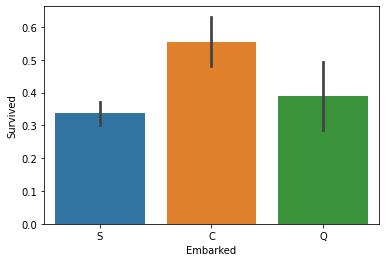

In [19]:
sns.barplot(x="Embarked", y="Survived", data=data)

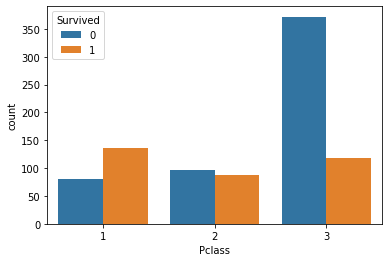

In [20]:
sns.countplot('Pclass', data=data, hue = "Survived")


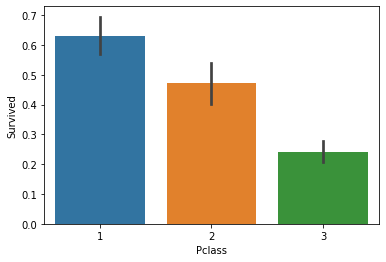

In [21]:
sns.barplot(x="Pclass", y="Survived", data=data)

C - это порт Шербург (Cherbourg) и судя по графикам, люди которые сели в этом порту имели больше шансов выжить. Но вряд ли это напрямую зависит от порта, нужны дополнительные исследования. Одна из мыслей была что в порту С село много женщин. И в процентном соотношении так и есть, но не понятно почему такая же тенденция не сохранилась в порту Q.

In [22]:
data[(data['Embarked']=='C')]['Sex'].value_counts()

male      95
female    73
Name: Sex, dtype: int64

In [23]:
data[(data['Embarked']=='S')]['Sex'].value_counts()

male      441
female    203
Name: Sex, dtype: int64

In [24]:
data[(data['Embarked']=='Q')]['Sex'].value_counts()

male      41
female    36
Name: Sex, dtype: int64

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [25]:
data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Возраст придется заменить на среднее или моду. Кабины вообще не нужны, мы не будем никак анализировать их расположение их можно просто выкинуть. В Embarked пропущено всего пару значений, можно проанализировать и заполнить недостающие самым распространенным значением или просто выкинуть из датасета.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [26]:
data = data[['Ticket', 'Pclass', 'Survived', 'Embarked', 'Age', 'SibSp',
       'Fare', 'Name', 'Sex', 'Parch']]

In [27]:
data_dropped = data.dropna(axis=0, how='any')
y = data_dropped['Survived']

In [28]:
data_dropped['Sex'] = data_dropped['Sex'].apply(lambda x: 1 if x=='male' else 0)

<ipython-input-28-3b54ea7391bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dropped['Sex'] = data_dropped['Sex'].apply(lambda x: 1 if x=='male' else 0)


In [29]:
data_dropped = data_dropped[['Pclass', 'Embarked', 'Age', 'SibSp', 'Fare', 'Sex', 'Parch']]

In [30]:
encoder = OneHotEncoder(sparse=False)
encoded_categorical_columns = encoder.fit_transform(data_dropped[['Embarked']])
embarked_encoder = pd.DataFrame(encoded_categorical_columns)
embarked_encoder

,0,1,2
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
707,0.0,1.0,0.0
708,0.0,0.0,1.0
709,0.0,0.0,1.0
710,1.0,0.0,0.0


In [31]:
data_dropped = data_dropped[['Pclass', 'Age', 'SibSp', 'Fare', 'Sex', 'Parch']]

In [32]:
X = pd.concat([data_dropped.reset_index(), embarked_encoder], axis=1, ignore_index=True)
X

,0,1,2,3,4,5,6,7,8,9
0,1,3,22.0,1,7.2500,1,0,0.0,0.0,1.0
1,2,1,38.0,1,71.2833,0,0,1.0,0.0,0.0
2,3,3,26.0,0,7.9250,0,0,0.0,0.0,1.0
3,4,1,35.0,1,53.1000,0,0,0.0,0.0,1.0
4,5,3,35.0,0,8.0500,1,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
707,886,3,39.0,0,29.1250,0,5,0.0,1.0,0.0
708,887,2,27.0,0,13.0000,1,0,0.0,0.0,1.0
709,888,1,19.0,0,30.0000,0,0,0.0,0.0,1.0
710,890,1,26.0,0,30.0000,1,0,1.0,0.0,0.0


In [34]:
encoder = OneHotEncoder(sparse=False)
encoded_categorical_columns = encoder.fit_transform(data_dropped[['Pclass']])
embarked_encoder = pd.DataFrame(encoded_categorical_columns)
embarked_encoder

,0,1,2
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
707,0.0,0.0,1.0
708,0.0,1.0,0.0
709,1.0,0.0,0.0
710,1.0,0.0,0.0


In [35]:
X

,0,1,2,3,4,5,6,7,8,9
0,1,3,22.0,1,7.2500,1,0,0.0,0.0,1.0
1,2,1,38.0,1,71.2833,0,0,1.0,0.0,0.0
2,3,3,26.0,0,7.9250,0,0,0.0,0.0,1.0
3,4,1,35.0,1,53.1000,0,0,0.0,0.0,1.0
4,5,3,35.0,0,8.0500,1,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
707,886,3,39.0,0,29.1250,0,5,0.0,1.0,0.0
708,887,2,27.0,0,13.0000,1,0,0.0,0.0,1.0
709,888,1,19.0,0,30.0000,0,0,0.0,0.0,1.0
710,890,1,26.0,0,30.0000,1,0,1.0,0.0,0.0


In [36]:
X = X[[0, 2, 3, 4, 5, 6, 7, 8 ,9]] # выкинули столбец который отвечал за Класс
X = pd.concat([X, embarked_encoder], axis=1, ignore_index=True)

In [37]:
X = X[[1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11]] # выкинули столбец который отвечал за ID пассажира
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.52766856,  0.52251079, -0.51637992, ..., -0.59032605,
        -0.56653751,  1.00281295],
       [ 0.57709388,  0.52251079,  0.69404605, ...,  1.69397911,
        -0.56653751, -0.99719495],
       [-0.25147795, -0.55271372, -0.50362035, ..., -0.59032605,
        -0.56653751,  1.00281295],
       ...,
       [-0.73481151, -0.55271372, -0.08633507, ...,  1.69397911,
        -0.56653751, -0.99719495],
       [-0.25147795, -0.55271372, -0.08633507, ...,  1.69397911,
        -0.56653751, -0.99719495],
       [ 0.16280796, -0.55271372, -0.50692839, ..., -0.59032605,
        -0.56653751,  1.00281295]])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [39]:
lr_best_clf = LogisticRegression(C=1, penalty='l1', random_state=42, max_iter=10000, solver='saga', n_jobs=-1)
lr_best_clf.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10000, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga')

In [40]:
y_pred = lr_best_clf.predict(X_test)

In [41]:
metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.7972027972027972

In [42]:
kn_best_clf = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1)
kn_best_clf.fit(X_train, y_train)
y_pred = kn_best_clf.predict(X_test)
metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.7972027972027972

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [43]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [44]:
data_test = data_test[['Ticket', 'Pclass', 'Embarked', 'Age', 'SibSp', 'Fare', 'Name', 'Sex', 'Parch']]
data_test_dropped = data_test.fillna(data_test.mean())
data_test_dropped['Sex'] = data_test_dropped['Sex'].apply(lambda x: 1 if x=='male' else 0)
data_test_dropped = data_test_dropped[['Pclass', 'Embarked', 'Age', 'SibSp', 'Fare', 'Sex', 'Parch']]
encoder = OneHotEncoder(sparse=False)
encoded_categorical_columns = encoder.fit_transform(data_test_dropped[['Embarked', 'Pclass']])
embarked_encoder = pd.DataFrame(encoded_categorical_columns)
data_test_dropped = data_test_dropped[['Age', 'SibSp', 'Fare', 'Sex', 'Parch']]
X = pd.concat([data_test_dropped.reset_index(), embarked_encoder], axis=1, ignore_index=True)
X = X[[1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11]]
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_column = lr_best_clf.predict(X)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [45]:
pd.concat([data_test.reset_index(), pd.DataFrame(y_column, columns=['Survived'])], axis=1, ignore_index=False)[['PassengerId', 'Survived']].to_csv('submission3.csv',index=False)

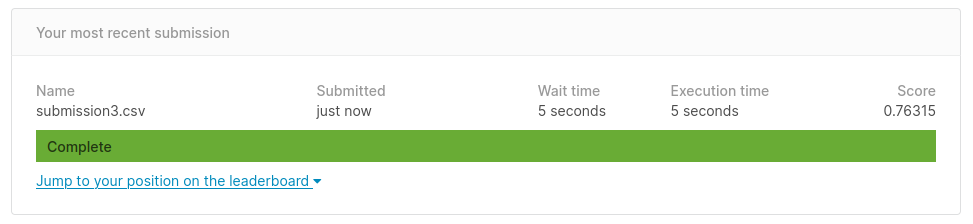

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code